In [1]:
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import Counter

import pandas as pd
import numpy as np

In [2]:
#settings
EPOCHS = 20
BATCH_SIZE = 128
CLASS_WEIGHT=[1, 1, 1] 
HIDDEN_DIM=64
#
MAX_LEN = 400

# Data Upload

In [4]:
df = pd.read_csv('HateSpeechTurkish.csv', encoding="utf-8-sig")

In [5]:
#df = df.head(1000)

In [6]:
history = {'loss': [], 'f1': [], 'val_loss': [], 'val_f1': []}

In [7]:
main_result = {'model_name': [],
               'Accuracy': [], 'Precision': [], 'Recall': [] , 'F1': [],
               'Train_Time': [] , 'Infer_Time': []}

In [8]:
if df.isnull().values.any():
    print(df.isnull().sum())
    df.dropna(inplace=True)

row_id                      0
tweet                       0
etiket                     55
corrected_tweet             0
correct_normalize_tweet     0
dtype: int64


In [9]:
print("After drop null value:")
print(df.isnull().sum())

After drop null value:
row_id                     0
tweet                      0
etiket                     0
corrected_tweet            0
correct_normalize_tweet    0
dtype: int64


In [10]:
df['etiket'].value_counts()

etiket
hiçbiri      7667
nefret       2336
saldırgan     166
Name: count, dtype: int64

In [11]:
print("Original data class distribution:", Counter(df['etiket']))

Original data class distribution: Counter({'hiçbiri': 7667, 'nefret': 2336, 'saldırgan': 166})


In [12]:
label_mapping={
 'nefret':     0,
 'saldırgan':  1,
 'hiçbiri':    2,
}

In [13]:
y = df['etiket'].map(label_mapping)

In [14]:
x = df['correct_normalize_tweet']

# FT-TRW2V(FineTune turkish Word2Vec)

In [16]:
from gensim.models import KeyedVectors

path = "embedding/trmodel_finetune.kv"  # değiştir!
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)
emb_dim = w2v_model.vector_size

In [17]:
print(emb_dim)

400


# NLP

In [19]:
special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN = special_tokens
PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0, 1, 2, 3

In [20]:
tokenized_sentences = [sentence.split() for sentence in x]
all_tokens = [token for sent in tokenized_sentences for token in sent]
vocab = special_tokens + sorted(set(all_tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}


In [21]:
import numpy as np
import torch

embedding_matrix = np.zeros((len(word2idx), emb_dim))
for word, idx in word2idx.items():
    if word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(emb_dim,))
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [22]:
def encode_sentence(sentence, word2idx, max_len):
    tokens = sentence.split()
    indices = [word2idx.get(w, UNK_IDX) for w in tokens]
    indices = [SOS_IDX] + indices + [EOS_IDX]
    if len(indices) < max_len:
        indices += [PAD_IDX] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices


encoded_data = [encode_sentence(sent, word2idx, MAX_LEN) for sent in x]


X = encoded_data

# Test train split

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)
print("x_train",len(X_train))
print("x_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("Number of unique classes in y_test:",len(set(y_test)))

x_train 9152
x_test 1017
y_train 9152
y_test 1017
Number of unique classes in y_test: 3


In [25]:
src_tensor = torch.tensor(X_train, dtype=torch.long)
trg_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
src_tensor_test = torch.tensor(X_test, dtype=torch.long)
trg_tensor_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
sample = torch.tensor(X_test[10:11], dtype=torch.long).to(device)  # Sample for inferece time test

cuda


In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(src_tensor, trg_tensor)
val_dataset = TensorDataset(src_tensor_test, trg_tensor_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# AdditiveAttention + FT-W2V

In [29]:
model_name='bahdanau_FT-W2V'

In [30]:
attention='additive'

In [31]:
OUTPUT_DIM =len(set(y))

In [32]:
from transformer_model.attention import AdditiveAttention
from train.trainSeq2Seq import train_seq2seq_model



attention = AdditiveAttention(hidden_dim=HIDDEN_DIM)

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.7717, F1: 0.3279 | Val_Loss: 0.6057, Val_F1: 0.2881
Epoch 02 | Loss: 0.6220, F1: 0.2864 | Val_Loss: 0.5957, Val_F1: 0.2881
Epoch 03 | Loss: 0.6171, F1: 0.2864 | Val_Loss: 0.5919, Val_F1: 0.2881
Epoch 04 | Loss: 0.6093, F1: 0.2864 | Val_Loss: 0.5849, Val_F1: 0.2881
Epoch 05 | Loss: 0.5981, F1: 0.2877 | Val_Loss: 0.5748, Val_F1: 0.2881
Epoch 06 | Loss: 0.5802, F1: 0.3030 | Val_Loss: 0.5593, Val_F1: 0.2972
Epoch 07 | Loss: 0.5580, F1: 0.3480 | Val_Loss: 0.5430, Val_F1: 0.3426
Epoch 08 | Loss: 0.5319, F1: 0.4019 | Val_Loss: 0.5248, Val_F1: 0.4044
Epoch 09 | Loss: 0.5014, F1: 0.4458 | Val_Loss: 0.5106, Val_F1: 0.4324
Epoch 10 | Loss: 0.4721, F1: 0.4802 | Val_Loss: 0.5005, Val_F1: 0.4577
Epoch 11 | Loss: 0.4381, F1: 0.5075 | Val_Loss: 0.4883, Val_F1: 0.4595
Epoch 12 | Loss: 0.4098, F1: 0.5261 | Val_Loss: 0.4966, Val_F1: 0.4645
Epoch 13 | Loss: 0.3843, F1: 0.5346 | Val_Loss: 0.4780, Val_F1: 0.4773
Epoch 14 | Loss: 0.3660, F1: 0.5515 | Val_Loss: 0.4777, Val_F1: 0.4817
Epoch 

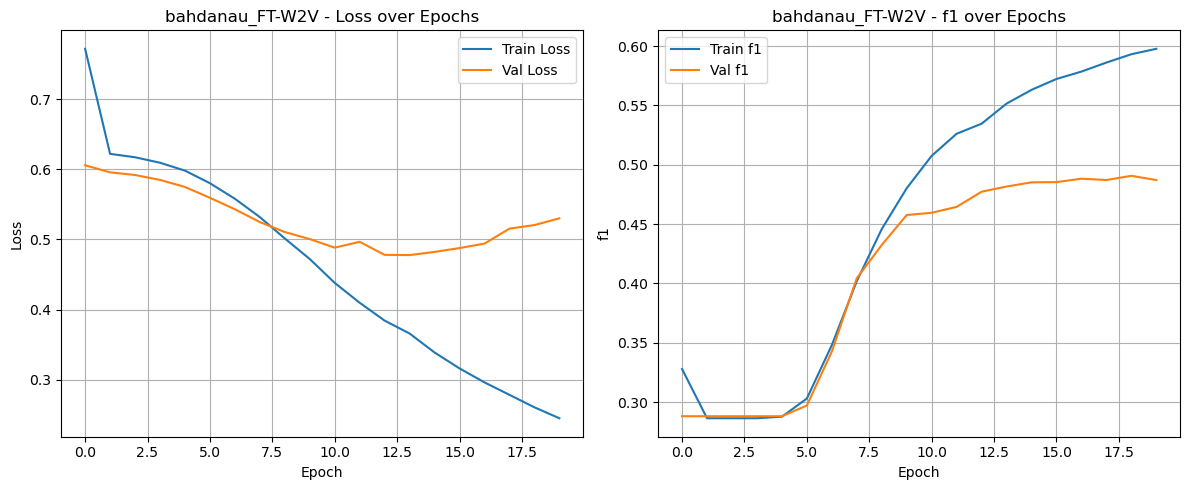

📈 Training history saved to: plots/saved/bahdanau_FT-W2V_plot.png


In [33]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)

from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [35]:
def test_inference(model,sample):
    start_infer = time.time()
    
    with torch.no_grad():
        output = model(sample)
        pred = output.argmax(dim=1).item()
        
    end_infer = time.time()
    
    infer_time = (end_infer - start_infer )* 1000
    
    print(f"\n🧠 Prediction for sample #10: Class {pred}")
    print(f"⚡ Inference Time for one sample : {infer_time:.2f} ms")
    return infer_time

In [36]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 0.54 ms


In [37]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

In [38]:
main_result

{'model_name': ['bahdanau_FT-W2V'],
 'Accuracy': [0.8190757128810227],
 'Precision': [0.5035667572864075],
 'Recall': [0.4779200838857058],
 'F1': [0.487105381520246],
 'Train_Time': [38135.5676651001],
 'Infer_Time': [0.5390644073486328]}

# AdditiveAttention + FreeEmbedding

In [40]:
model_name='bahdanau_FE'

In [41]:
attention='additive'

In [42]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.7930, F1: 0.3130 | Val_Loss: 0.6120, Val_F1: 0.2881
Epoch 02 | Loss: 0.6238, F1: 0.2864 | Val_Loss: 0.5988, Val_F1: 0.2881
Epoch 03 | Loss: 0.6213, F1: 0.2864 | Val_Loss: 0.5968, Val_F1: 0.2881
Epoch 04 | Loss: 0.6157, F1: 0.2864 | Val_Loss: 0.5956, Val_F1: 0.2881
Epoch 05 | Loss: 0.6110, F1: 0.2864 | Val_Loss: 0.5922, Val_F1: 0.2881
Epoch 06 | Loss: 0.6022, F1: 0.2873 | Val_Loss: 0.5897, Val_F1: 0.2881
Epoch 07 | Loss: 0.5921, F1: 0.2944 | Val_Loss: 0.5881, Val_F1: 0.2912
Epoch 08 | Loss: 0.5815, F1: 0.3140 | Val_Loss: 0.5859, Val_F1: 0.3097
Epoch 09 | Loss: 0.5715, F1: 0.3375 | Val_Loss: 0.5874, Val_F1: 0.3361
Epoch 10 | Loss: 0.5604, F1: 0.3630 | Val_Loss: 0.5832, Val_F1: 0.3299
Epoch 11 | Loss: 0.5472, F1: 0.3780 | Val_Loss: 0.5820, Val_F1: 0.3532
Epoch 12 | Loss: 0.5332, F1: 0.4006 | Val_Loss: 0.5792, Val_F1: 0.3636
Epoch 13 | Loss: 0.5202, F1: 0.4166 | Val_Loss: 0.5839, Val_F1: 0.3559
Epoch 14 | Loss: 0.5048, F1: 0.4306 | Val_Loss: 0.5801, Val_F1: 0.3898
Epoch 

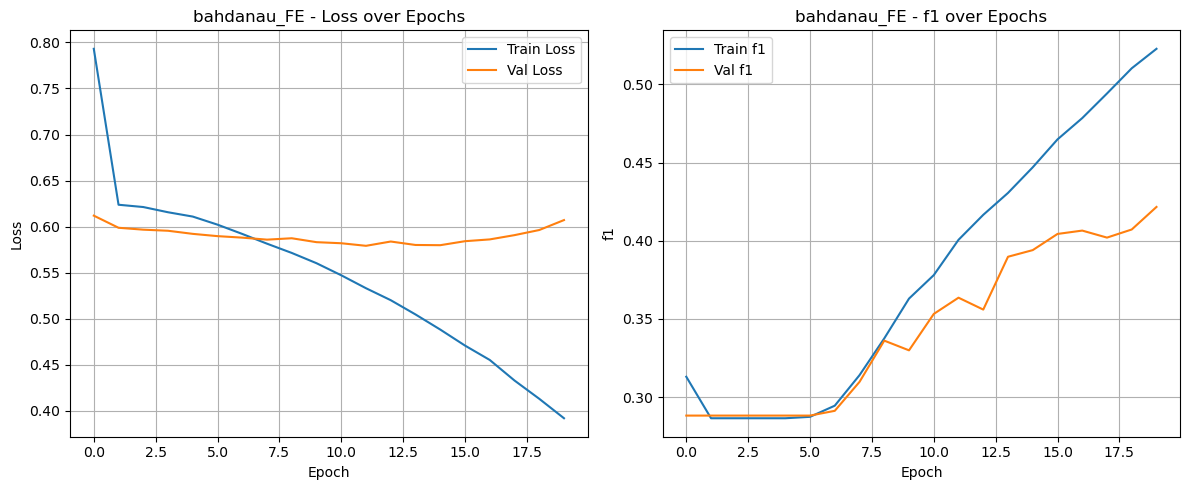

📈 Training history saved to: plots/saved/bahdanau_FE_plot.png


In [43]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - bahdanau_FE
Accuracy  : 0.7650
Precision : 0.4402
Recall    : 0.4155
F1 Score  : 0.4216


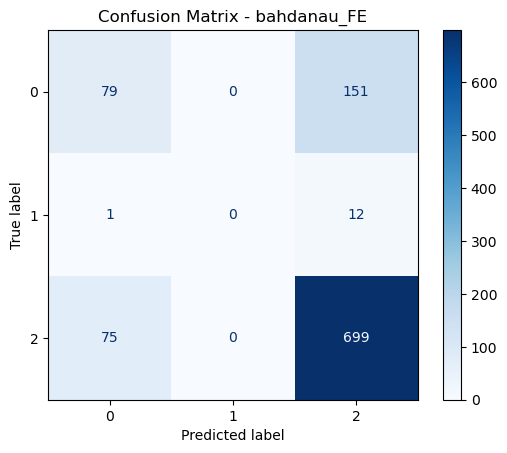

📌 Confusion matrix saved to: plots/saved/bahdanau_FE_csmtx.png


In [44]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [45]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 1.97 ms


In [46]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FT-W2V

In [48]:
model_name='Luong_FT-W2V'

In [49]:
attention='dot'

In [50]:
from transformer_model.attention import DotProductAttention
attention = DotProductAttention()

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.7287, F1: 0.2862 | Val_Loss: 0.6059, Val_F1: 0.2881
Epoch 02 | Loss: 0.6199, F1: 0.2864 | Val_Loss: 0.5973, Val_F1: 0.2881
Epoch 03 | Loss: 0.6145, F1: 0.2864 | Val_Loss: 0.5960, Val_F1: 0.2881
Epoch 04 | Loss: 0.6123, F1: 0.2864 | Val_Loss: 0.5920, Val_F1: 0.2881
Epoch 05 | Loss: 0.6046, F1: 0.2867 | Val_Loss: 0.5854, Val_F1: 0.2881
Epoch 06 | Loss: 0.5938, F1: 0.2917 | Val_Loss: 0.5749, Val_F1: 0.2881
Epoch 07 | Loss: 0.5763, F1: 0.3130 | Val_Loss: 0.5605, Val_F1: 0.3131
Epoch 08 | Loss: 0.5504, F1: 0.3625 | Val_Loss: 0.5461, Val_F1: 0.3378
Epoch 09 | Loss: 0.5299, F1: 0.4098 | Val_Loss: 0.5248, Val_F1: 0.4166
Epoch 10 | Loss: 0.4972, F1: 0.4497 | Val_Loss: 0.5113, Val_F1: 0.4156
Epoch 11 | Loss: 0.4717, F1: 0.4811 | Val_Loss: 0.5040, Val_F1: 0.4432
Epoch 12 | Loss: 0.4471, F1: 0.5029 | Val_Loss: 0.4887, Val_F1: 0.4446
Epoch 13 | Loss: 0.4243, F1: 0.5163 | Val_Loss: 0.4825, Val_F1: 0.4604
Epoch 14 | Loss: 0.4015, F1: 0.5302 | Val_Loss: 0.4860, Val_F1: 0.4500
Epoch 

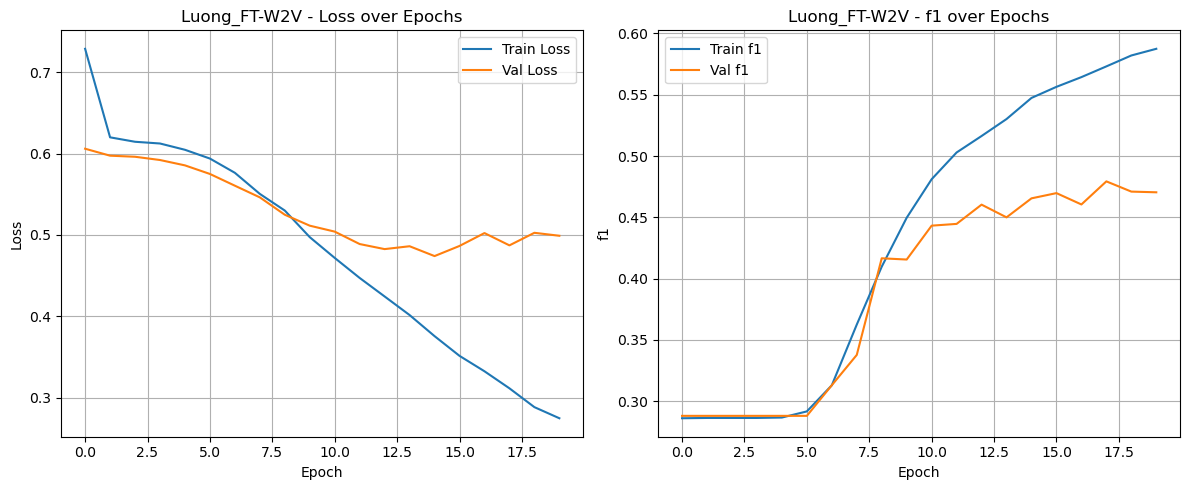

📈 Training history saved to: plots/saved/Luong_FT-W2V_plot.png


In [51]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - Luong_FT-W2V
Accuracy  : 0.7945
Precision : 0.4740
Recall    : 0.4682
F1 Score  : 0.4704


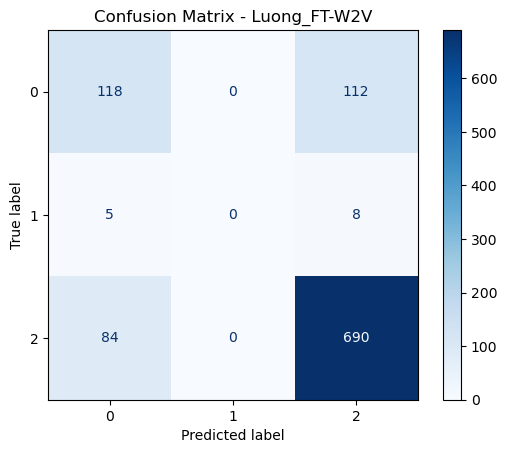

📌 Confusion matrix saved to: plots/saved/Luong_FT-W2V_csmtx.png


In [52]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [53]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 2.29 ms


In [54]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FE

In [56]:
model_name='Luong_FE'

In [57]:
attention='dot'

In [58]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.7344, F1: 0.3325 | Val_Loss: 0.6053, Val_F1: 0.2881
Epoch 02 | Loss: 0.6246, F1: 0.2864 | Val_Loss: 0.5989, Val_F1: 0.2881
Epoch 03 | Loss: 0.6185, F1: 0.2864 | Val_Loss: 0.5966, Val_F1: 0.2881
Epoch 04 | Loss: 0.6151, F1: 0.2864 | Val_Loss: 0.5937, Val_F1: 0.2881
Epoch 05 | Loss: 0.6072, F1: 0.2864 | Val_Loss: 0.5909, Val_F1: 0.2881
Epoch 06 | Loss: 0.6018, F1: 0.2864 | Val_Loss: 0.5879, Val_F1: 0.2881
Epoch 07 | Loss: 0.5909, F1: 0.2900 | Val_Loss: 0.5857, Val_F1: 0.2881
Epoch 08 | Loss: 0.5803, F1: 0.3119 | Val_Loss: 0.5846, Val_F1: 0.3190
Epoch 09 | Loss: 0.5732, F1: 0.3362 | Val_Loss: 0.5815, Val_F1: 0.3247
Epoch 10 | Loss: 0.5612, F1: 0.3642 | Val_Loss: 0.5766, Val_F1: 0.3304
Epoch 11 | Loss: 0.5480, F1: 0.3822 | Val_Loss: 0.5734, Val_F1: 0.3373
Epoch 12 | Loss: 0.5370, F1: 0.4039 | Val_Loss: 0.5710, Val_F1: 0.3649
Epoch 13 | Loss: 0.5204, F1: 0.4215 | Val_Loss: 0.5683, Val_F1: 0.3416
Epoch 14 | Loss: 0.5031, F1: 0.4380 | Val_Loss: 0.5653, Val_F1: 0.3713
Epoch 

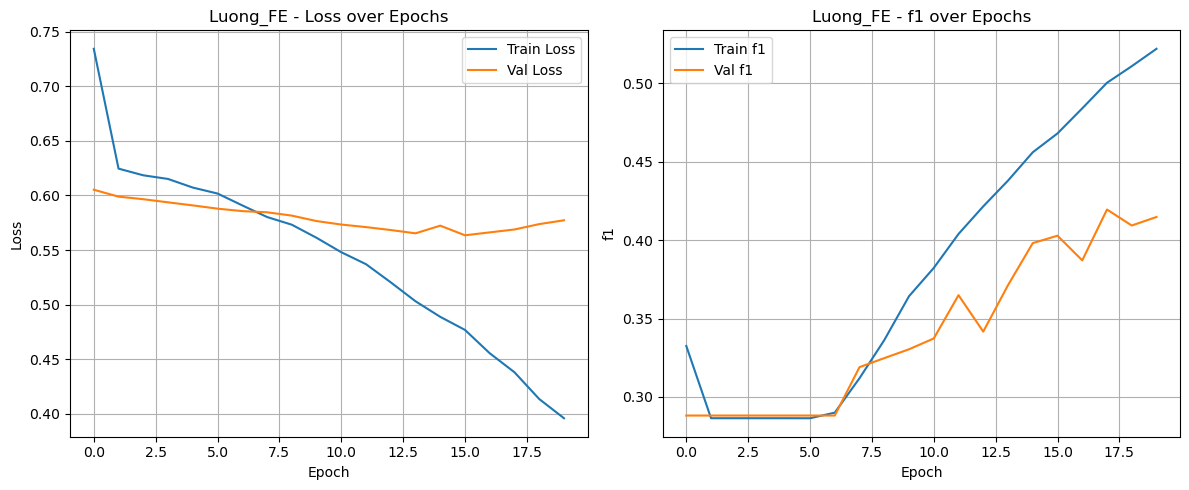

📈 Training history saved to: plots/saved/Luong_FE_plot.png


In [59]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - Luong_FE
Accuracy  : 0.7670
Precision : 0.4413
Recall    : 0.4082
F1 Score  : 0.4147


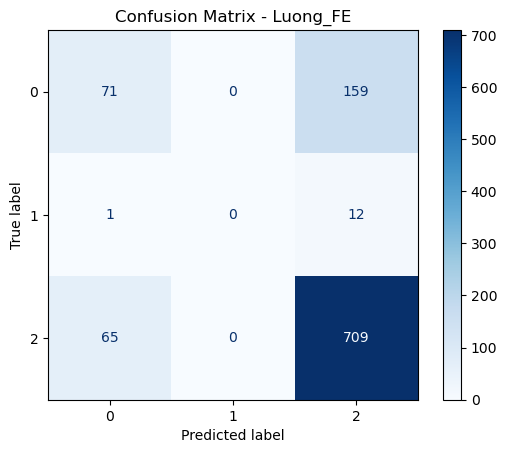

📌 Confusion matrix saved to: plots/saved/Luong_FE_csmtx.png


In [60]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [61]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 4.01 ms


In [62]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# Scaled-dotProduct + FT-W2V

In [64]:
model_name='scaled-dot_FT-W2V'

In [65]:
attention='scaled_dot'

In [66]:
from transformer_model.attention import ScaledDotProductAttention
attention = ScaledDotProductAttention(hidden_dim=HIDDEN_DIM)

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.7569, F1: 0.2948 | Val_Loss: 0.6094, Val_F1: 0.2881
Epoch 02 | Loss: 0.6249, F1: 0.2864 | Val_Loss: 0.5986, Val_F1: 0.2881
Epoch 03 | Loss: 0.6186, F1: 0.2864 | Val_Loss: 0.5953, Val_F1: 0.2881
Epoch 04 | Loss: 0.6152, F1: 0.2864 | Val_Loss: 0.5928, Val_F1: 0.2881
Epoch 05 | Loss: 0.6093, F1: 0.2864 | Val_Loss: 0.5877, Val_F1: 0.2881
Epoch 06 | Loss: 0.6016, F1: 0.2886 | Val_Loss: 0.5796, Val_F1: 0.2881
Epoch 07 | Loss: 0.5894, F1: 0.2973 | Val_Loss: 0.5692, Val_F1: 0.3001
Epoch 08 | Loss: 0.5689, F1: 0.3321 | Val_Loss: 0.5503, Val_F1: 0.3245
Epoch 09 | Loss: 0.5418, F1: 0.3760 | Val_Loss: 0.5246, Val_F1: 0.3729
Epoch 10 | Loss: 0.5114, F1: 0.4364 | Val_Loss: 0.5079, Val_F1: 0.4041
Epoch 11 | Loss: 0.4818, F1: 0.4692 | Val_Loss: 0.4869, Val_F1: 0.4562
Epoch 12 | Loss: 0.4505, F1: 0.4956 | Val_Loss: 0.4758, Val_F1: 0.4673
Epoch 13 | Loss: 0.4286, F1: 0.5083 | Val_Loss: 0.4703, Val_F1: 0.4724
Epoch 14 | Loss: 0.4004, F1: 0.5238 | Val_Loss: 0.4698, Val_F1: 0.4691
Epoch 

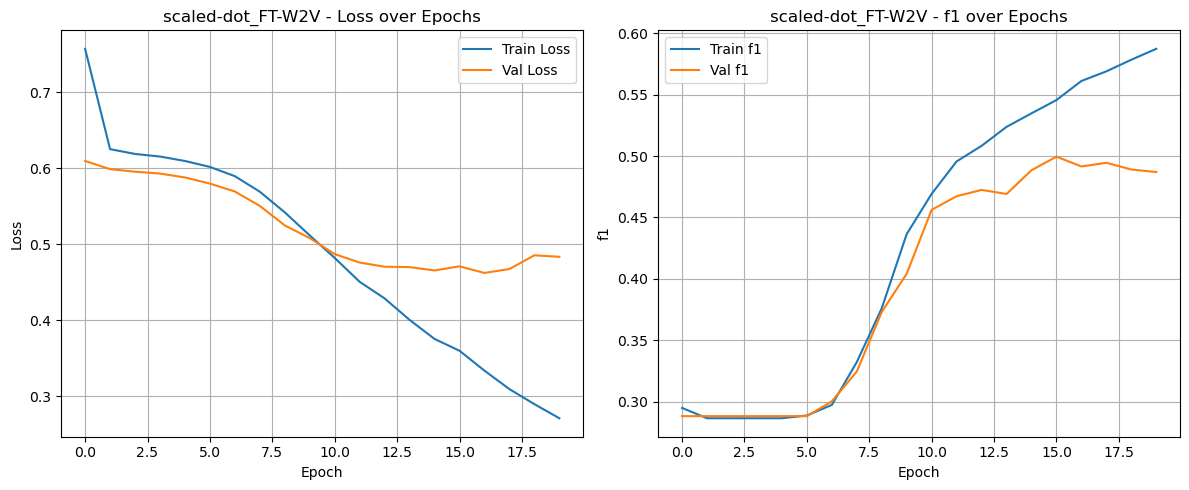

📈 Training history saved to: plots/saved/scaled-dot_FT-W2V_plot.png


In [67]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - scaled-dot_FT-W2V
Accuracy  : 0.8230
Precision : 0.5095
Recall    : 0.4756
F1 Score  : 0.4870


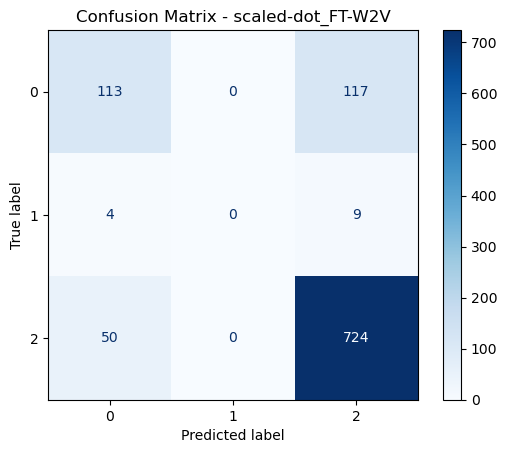

📌 Confusion matrix saved to: plots/saved/scaled-dot_FT-W2V_csmtx.png


In [68]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [69]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 1.95 ms


In [70]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# Scaled-dotProduct + FE

In [72]:
model_name='scaled-dot_FE'

In [73]:
attention='scaled_dot'

In [74]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 0.8196, F1: 0.2778 | Val_Loss: 0.6243, Val_F1: 0.2881
Epoch 02 | Loss: 0.6271, F1: 0.2864 | Val_Loss: 0.5997, Val_F1: 0.2881
Epoch 03 | Loss: 0.6223, F1: 0.2864 | Val_Loss: 0.5980, Val_F1: 0.2881
Epoch 04 | Loss: 0.6154, F1: 0.2864 | Val_Loss: 0.5963, Val_F1: 0.2881
Epoch 05 | Loss: 0.6104, F1: 0.2864 | Val_Loss: 0.5954, Val_F1: 0.2881
Epoch 06 | Loss: 0.6001, F1: 0.2877 | Val_Loss: 0.5935, Val_F1: 0.2881
Epoch 07 | Loss: 0.5897, F1: 0.2979 | Val_Loss: 0.5915, Val_F1: 0.2937
Epoch 08 | Loss: 0.5824, F1: 0.3200 | Val_Loss: 0.5903, Val_F1: 0.2983
Epoch 09 | Loss: 0.5708, F1: 0.3388 | Val_Loss: 0.5882, Val_F1: 0.3114
Epoch 10 | Loss: 0.5550, F1: 0.3614 | Val_Loss: 0.5859, Val_F1: 0.3236
Epoch 11 | Loss: 0.5447, F1: 0.3831 | Val_Loss: 0.5844, Val_F1: 0.3276
Epoch 12 | Loss: 0.5300, F1: 0.4023 | Val_Loss: 0.5805, Val_F1: 0.3397
Epoch 13 | Loss: 0.5172, F1: 0.4196 | Val_Loss: 0.5780, Val_F1: 0.3870
Epoch 14 | Loss: 0.4997, F1: 0.4429 | Val_Loss: 0.5713, Val_F1: 0.3941
Epoch 

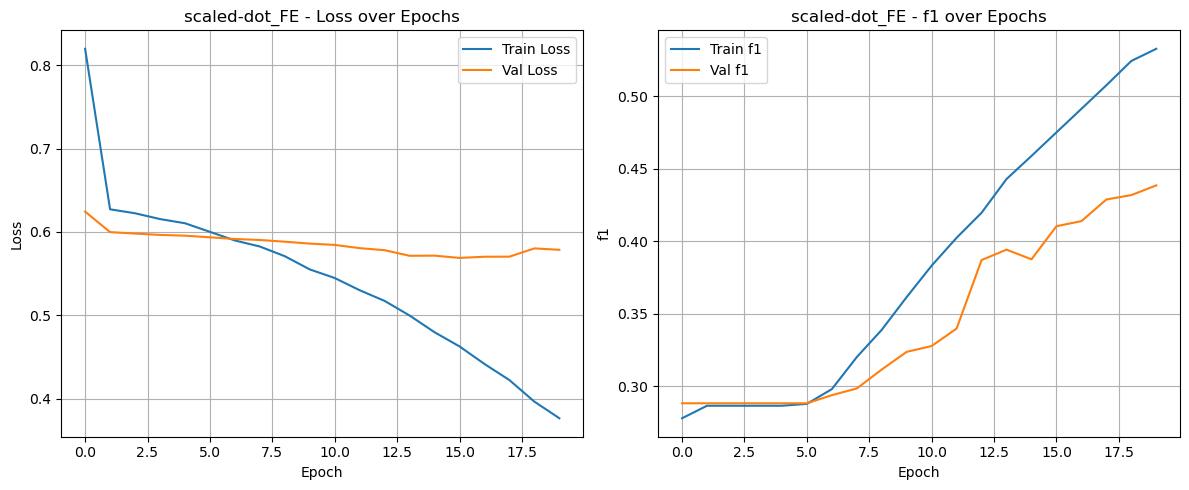

📈 Training history saved to: plots/saved/scaled-dot_FE_plot.png


In [75]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - scaled-dot_FE
Accuracy  : 0.7778
Precision : 0.4531
Recall    : 0.4323
F1 Score  : 0.4385


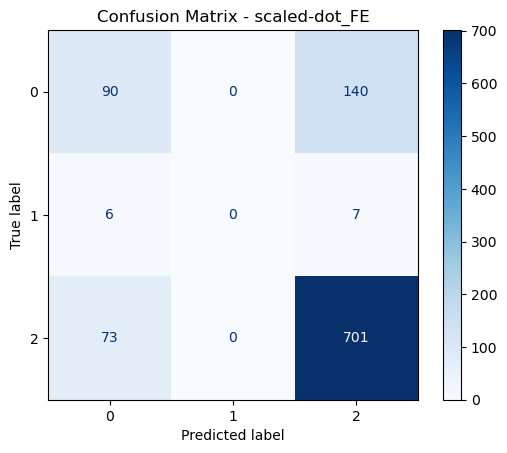

📌 Confusion matrix saved to: plots/saved/scaled-dot_FE_csmtx.png


In [76]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [77]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 0.00 ms


In [78]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# result

In [80]:
main_result

{'model_name': ['bahdanau_FT-W2V',
  'bahdanau_FE',
  'Luong_FT-W2V',
  'Luong_FE',
  'scaled-dot_FT-W2V',
  'scaled-dot_FE'],
 'Accuracy': [0.8190757128810227,
  0.7649950835791544,
  0.7944936086529006,
  0.7669616519174042,
  0.8230088495575221,
  0.7777777777777778],
 'Precision': [0.5035667572864075,
  0.4401940972482099,
  0.473966720343532,
  0.44130999778809993,
  0.5094704708230599,
  0.4530651073648171],
 'Recall': [0.4779200838857058,
  0.4155263453544546,
  0.46817211549264126,
  0.4082387746695128,
  0.47556828820731756,
  0.4323297007826836],
 'F1': [0.487105381520246,
  0.42163761259115784,
  0.47041929593417003,
  0.4147455264918009,
  0.4869650457247087,
  0.43849760035106256],
 'Train_Time': [38135.5676651001,
  38095.12734413147,
  38424.62730407715,
  38246.365547180176,
  38240.10372161865,
  38471.35901451111],
 'Infer_Time': [0.5390644073486328,
  1.9702911376953125,
  2.2881031036376953,
  4.006862640380859,
  1.9516944885253906,
  0.0]}

(<Figure size 1800x1000 with 3 Axes>,
 (<Axes: title={'center': 'Model Performance Metrics'}, ylabel='Value'>,
  <Axes: title={'center': 'Model Training and Inference Times'}, xlabel='Model', ylabel='Training Time (seconds)'>,
  <Axes: ylabel='Inference Time (seconds)'>))

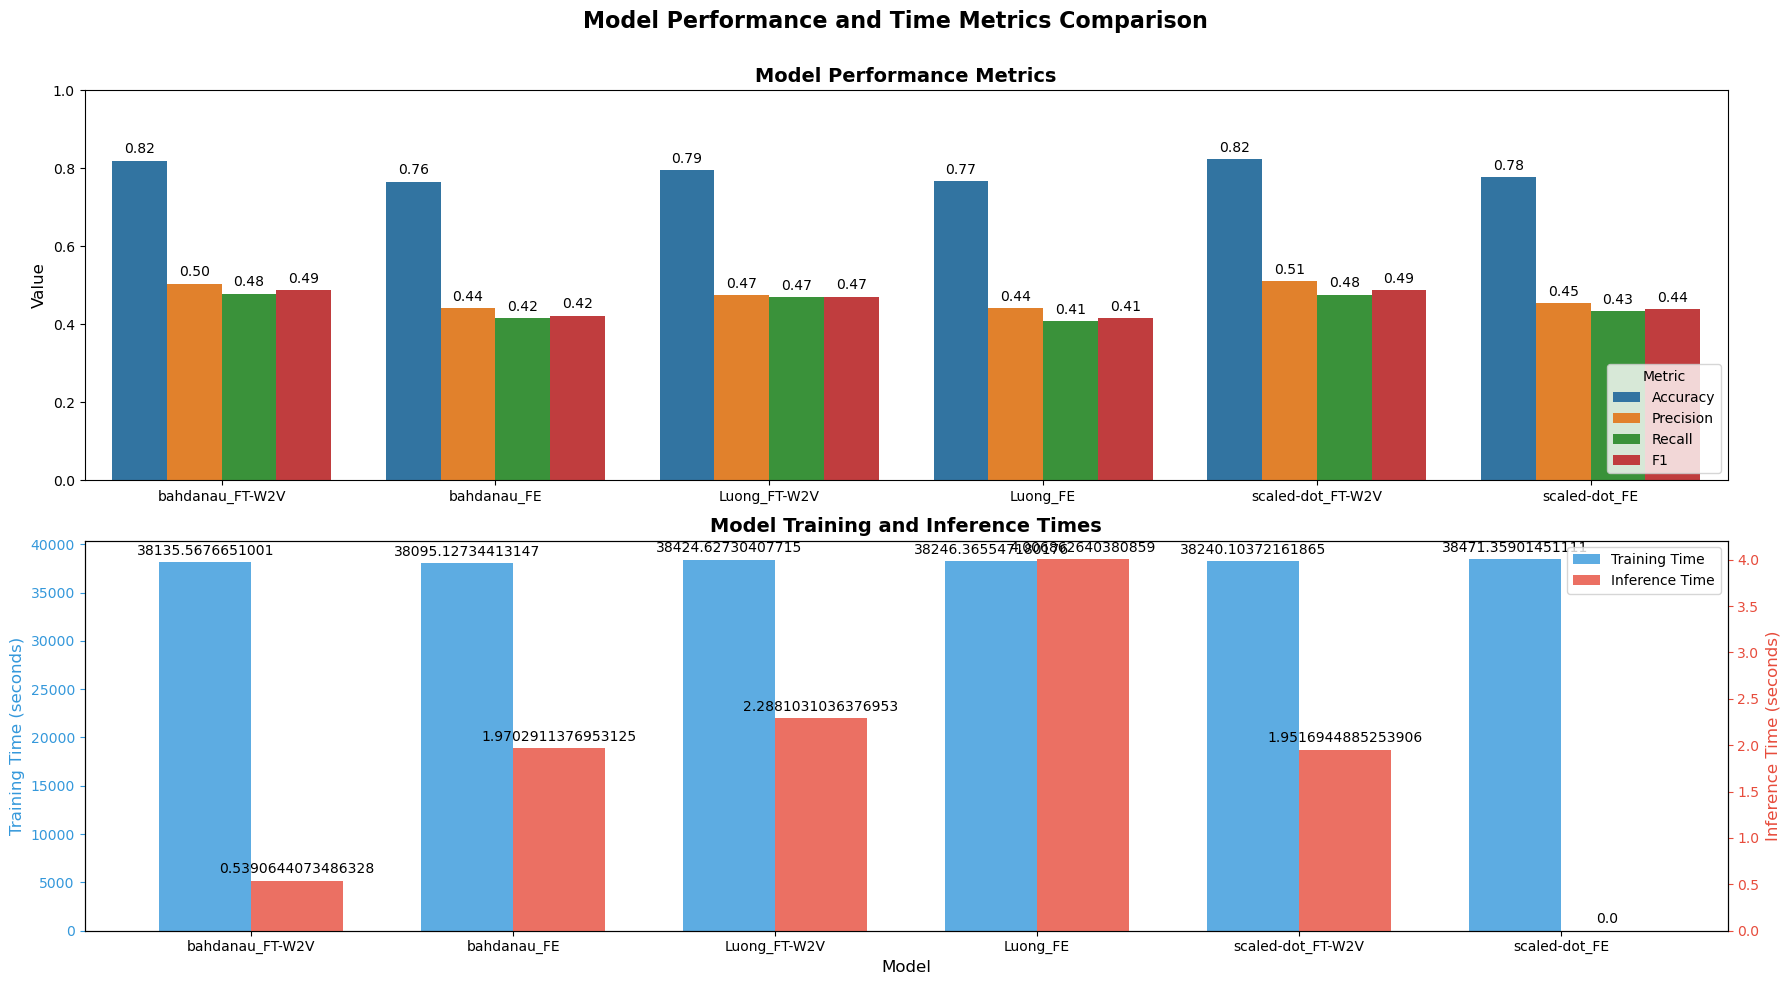

In [81]:
from plots.time_metric import plot_all_model_metrics

plot_all_model_metrics(main_result)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Model Performance Metrics Comparison'}, xlabel='Model', ylabel='Value'>)

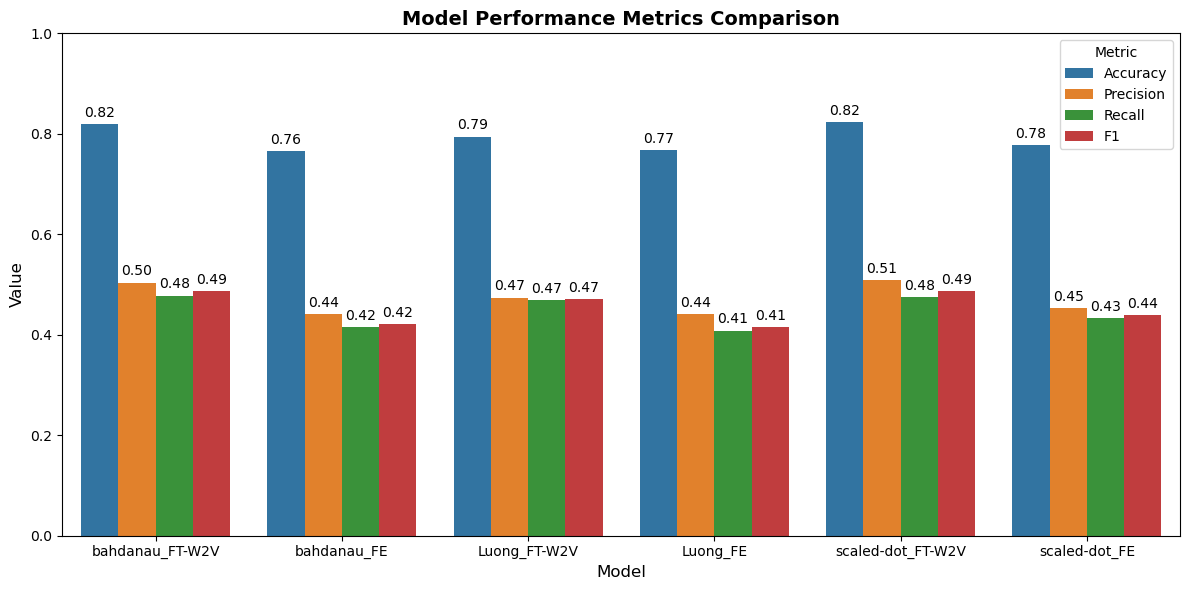

In [82]:
from plots.time_metric import plot_performance_metrics
plot_performance_metrics(main_result)

In [83]:
# AdditiveAttention + FT-W2V